# CSE 152A Winter 2024 – Assignment 4 Solution

Assignment Published On: **Sat, Mar 2, 2024**

Due On: **Tue, Mar 12, 2024 11:59 PM (Pacific Time)**

Instructions:
- Attempt all questions.
- Please comment all your code adequately.
- **Please install following packages in order to run the code: PyTorch, Torchvision, matplotlib, scikit-learn**
- Please write your code at the ``WRITE YOUR CODE HERE'' prompt in the .ipynb file. 

# 1. Backpropogation [10 Points]

We will study the backpropagation behavior for a  [sigmoid neuron](https://en.wikipedia.org/wiki/Sigmoid_function), given by:

$$
f(z) = \frac{1}{1+e^{-z}}
$$

Consider a two-dimensional input given by $x = (x_1, x_2)^T$. A weight vector $w = (w_1, w_2)^T$ and a bias $b$ act on it. Thus, the output of a neuron is given by $f(x_1, x_2) = \frac{1}{1+e^{-(w_1x_1+w_2x_2+b)}}$.
\
\
(a.) Draw the computational graph for the neuron in terms of elementary operations (addition, subtraction, multiplication, division, exponentiation) as seen in class. **[2 points]**

(b.) Consider inputs $x_1 = 0.3, x_2=0.4,$ weights $w_1 = 0.3, w_2 = 0.6$ and bias $b = 0.2$. In the same figure, show the values at each node of the graph during forward propagation. **[2 points]**

(c.) Use backpropagation to determine the gradients $\frac{\partial f}{\partial w_1}, \frac{\partial f}{\partial w_2}, \frac{\partial f}{\partial b}$. Also illustrate in the same figure the intermediate gradients at each node of the computation graph. **[4 points]**

(d.) Explain the process of backpropagation you used to compute partial derivatives. **[2 points]**

![title](solution.png)

### - a,b,c from above

- d. Backpropogation works by computing a chain of gradients starting from the last (output) node and moving backward to the inputs, while computing all intermediate gradients in between. Typically, the values computed during the forward pass are stored temporarily to ease the computation of gradients.

# 2. Training a small CNN for MNIST digit classification [15 Points]

In this problem, you will train a small convolutional neural network for image classification, using PyTorch. We will use the MNIST dataset for digit classification (http://yann.lecun.com/exdb/mnist/)

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100.0%
17.9%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100.0%
100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



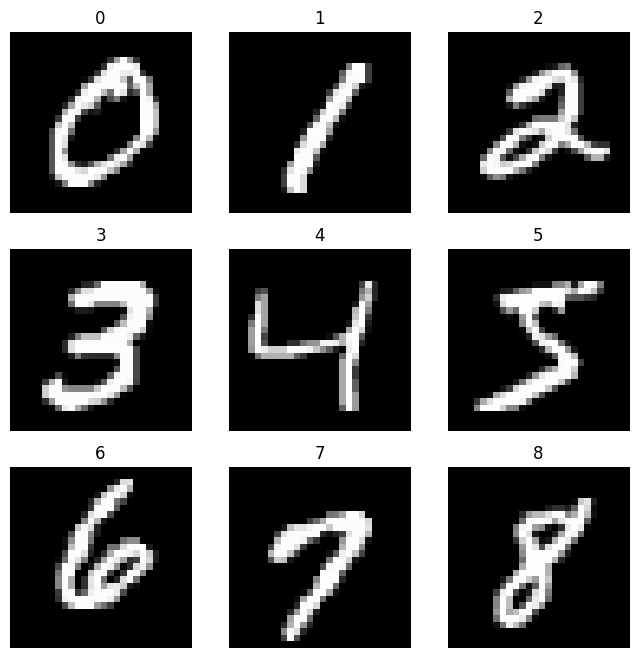

Image Shape: torch.Size([1, 28, 28])


In [4]:
# Load in the datasets

# Download the MNIST Datasets (you will use these variables later on)
MNIST_train = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

MNIST_test = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Code adapted from PyTorch https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
train_labels = MNIST_train.targets
label = (train_labels == 0).nonzero()
for i in range(1, cols * rows + 1):
    # Select image of each label
    indices = (train_labels == i-1).nonzero()
    sample_idx = indices[0,0]
    img, label = MNIST_train[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(i-1)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

print(f"Image Shape: {img.shape}")

In [15]:
# Check device
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using {device} device")

Using cpu device


**[ 3 points ] Define the network structure as follows**

* Convolutional layer with 32 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Convolutional layer with 64 kernels, window size 5, padding size 2, stride 1
* In place ReLU activation layer
* Max pooling layer with window size 2, stride 2
* Fully connected layer with 1024 output channels
* In place ReLU activation layer
* Dropout layer with drop rate 0.4
* Fully connected layer with 10 output channels

In [6]:
class Net(nn.Module):
    def __init__(self,drop):
        super(Net, self).__init__()
        self.drop = drop
        # DEFINE THE NETWORK STRUCTURE

        # Example: self.conv1 = nn.Conv2d(1, 3, 5,stride=1,padding=2,bias=True)
        # You can look at the main PyTorch tutorial for reference
        # https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

        # * Convolutional layer with 32 kernels, window size 5, padding size 2, stride 1
        # * In place ReLU activation layer
        # * Max pooling layer with window size 2, stride 2
        # * Convolutional layer with 64 kernels, window size 5, padding size 2, stride 1
        # * In place ReLU activation layer
        # * Max pooling layer with window size 2, stride 2
        # * Fully connected layer with 1024 output channels
        # * In place ReLU activation layer
        # * Dropout layer with drop rate 0.4
        # * Fully connected layer with 10 output channels
        
        # --------------- YOUR CODE HERE ---------------
        self.layer1 = nn.Conv2d(1, 32, 5, stride=1, padding=2)
        self.layer2 = nn.Conv2d(32, 64, 5, stride=1, padding=2)
        self.layer3 = nn.Linear(64*7*7, 1024)
        self.dropout = nn.Dropout(p=0.4)
        self.fc = nn.Linear(1024, 10)

        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(2, stride=2)
        

    def forward(self, x):
        
        # --------------- YOUR CODE HERE ---------------
        x = self.layer1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer2(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = x.view(-1, 64*7*7)
        x = self.layer3(x)
        x = self.relu(x)

        if self.drop:
            x = self.dropout(x)

        x = self.fc(x)
        
        return x

# Print net
net = Net(drop=True).to(device)
print(net)

Net(
  (layer1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (layer3): Linear(in_features=3136, out_features=1024, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (fc): Linear(in_features=1024, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


**[ 5 points ] Complete the train function below. Use the same parameters to perform training in each of the following setups:**

* SGD for optimization, without dropout
* SGD for optimization, with dropout
* Adam for optimization, without dropout
* Adam for optimization, with dropout.

As evaluation for each case above, perform the following:
* Plot the loss graph and the accuracy graph on training set on the same plot
* Print the accuracy on test set after training

Test accuracies are expected to be quite high (~98 %) for all networks.

Training can take a few minutes.

In [7]:
# CODE BELOW IS AN EXAMPLE STARTER
# FEEL FREE TO EDIT ANYTHING

# 'to_train' is a parameter that determines what part of the net to train.
# It is not required for this question, but will be useful in the next one.
# You should also change the parameters: epochs, batch, and learning rate as necessary.
# You may need to tune these hyperparameters.
def train(train_dataset, net, to_train, opt, epochs=10, batch=200, learning_rate=1e-3):
    # Initialize loss
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist=[]

    # Create dataloader
    MNIST_train_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True)

    # Select optimizer
    if(opt=='adam'):
        optimizer = optim.Adam(to_train,lr=learning_rate)
    else:
        optimizer = optim.SGD(to_train,lr=learning_rate,momentum = 0.99)
    optimizer.zero_grad()

    # Set model to training mode
    net.train()
    for k in tqdm(range(epochs)):
        for it, (X,y) in enumerate(MNIST_train_dataloader):
            # Send to device
            X, y = X.to(device), y.to(device)

            # Train the model using the optimizer and the batch data.
            # Append the loss and accuracy from each iteration to the losslist and acclist arrays
            # --------------- YOUR CODE HERE ---------------
            pred = net(X)
            loss = criterion(pred, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losslist.append(loss.item())
            acclist.append((pred.argmax(1) == y).type(torch.float).mean().item())

    return losslist,acclist

# Used to test or evaluate your network. Already written for you.
def test(test_dataset, net):
    batch = 200
    test_dataloader = DataLoader(test_dataset, batch_size=batch)
    size = len(test_dataloader.dataset)

    # Set model to eval mode
    net.eval()

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_dataloader:
            # Send to device
            X, y = X.to(device), y.to(device)

            # Prediction
            pred = net(X)

            # Calculate number of correct predictions in the batch
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # Compute total accuracy
    acc = correct / size
    return acc

100%|██████████| 10/10 [06:35<00:00, 39.56s/it]


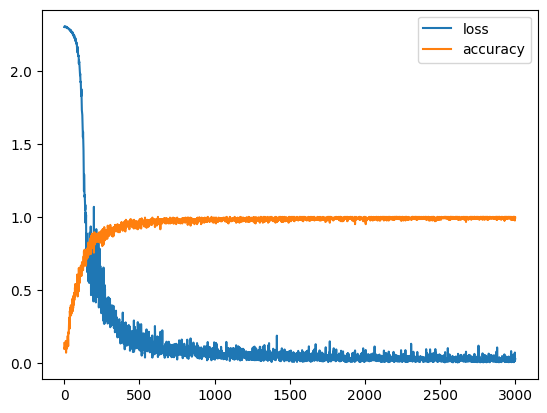

Accuracy:0.9902


In [8]:
# SGD with no dropout
# Example code
net = Net(drop=False).to(device)
loss1, acc1 = train(MNIST_train, net, net.parameters(), 'sgd')
ax=range(len(loss1))
plt.plot(ax, loss1, ax, acc1)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

100%|██████████| 10/10 [06:56<00:00, 41.61s/it]


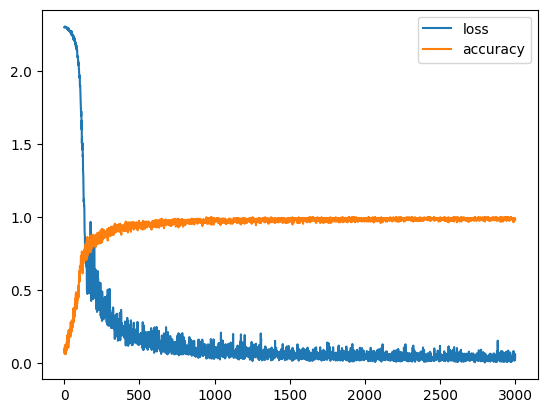

Accuracy:0.9895


In [9]:
# SGD with dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=True).to(device)
loss2, acc2 = train(MNIST_train, net, net.parameters(), 'sgd')
ax=range(len(loss2))
plt.plot(ax, loss2, ax, acc2)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

100%|██████████| 10/10 [07:01<00:00, 42.15s/it]


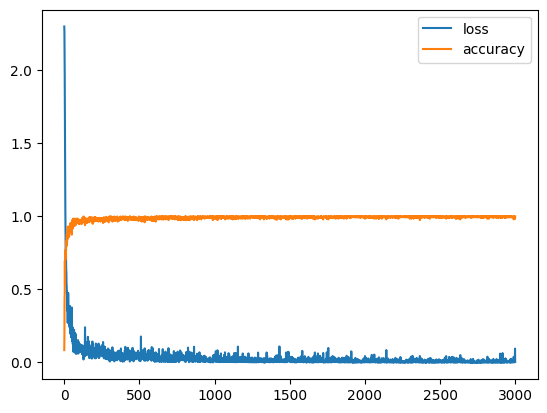

Accuracy:0.9898


In [10]:
# Adam with no dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=False).to(device)
loss3, acc3 = train(MNIST_train, net, net.parameters(), 'adam')
ax=range(len(loss3))
plt.plot(ax, loss3, ax, acc3)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

100%|██████████| 10/10 [07:00<00:00, 42.09s/it]


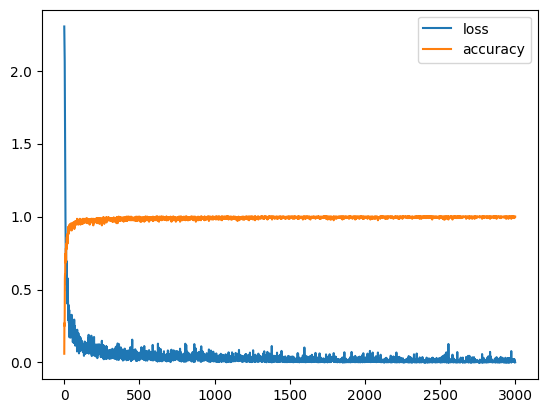

Accuracy:0.9936


In [11]:
# Adam with dropout
# --------------- YOUR CODE HERE ---------------
net = Net(drop=True).to(device)
loss4, acc4 = train(MNIST_train, net, net.parameters(), 'adam')
ax=range(len(loss4))
plt.plot(ax, loss4, ax, acc4)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(test(MNIST_test, net)))

**[ 5 points ] Plot the following graphs and note your observations**

* Training loss graphs of SGD−dropout and Adam−dropout on the same plot.
* Training loss graphs for Adam-dropout for 3 different values of batch sizes of 10, 200 and 500, on the same plot.

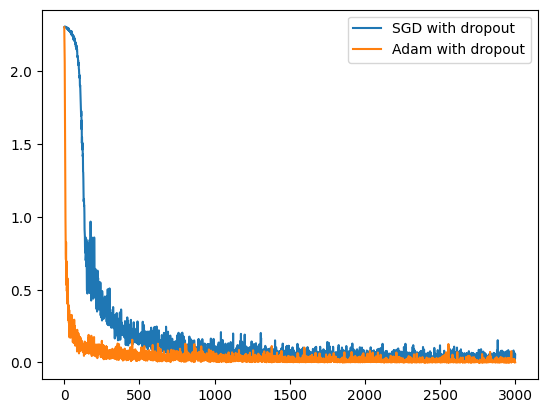

In [12]:
# --------------- YOUR CODE HERE ---------------
ax=range(len(loss2))
plt.plot(ax, loss2, ax, loss4)
plt.legend(['SGD with dropout', 'Adam with dropout'])
plt.show()

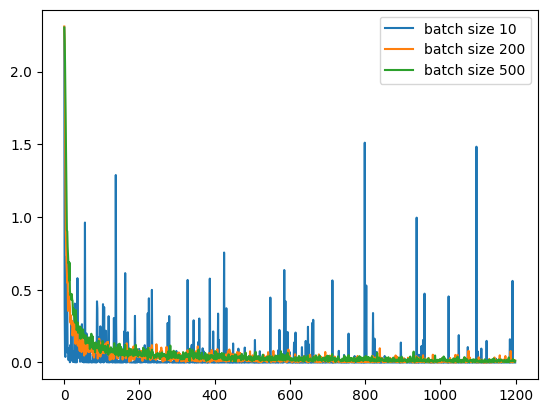

In [16]:
loss_graphs = []
for batch_size in [10, 200, 500]:
    net = Net(drop=True).to(device)
    loss, acc = train(MNIST_train, net, net.parameters(), 'adam', batch=batch_size)
    print('Batch size:{}'.format(batch_size))
    print('Accuracy:{}'.format(test(MNIST_test, net)))
    loss_graphs.append(loss)

## make all lists inside loss_graphs same length by subsampling
min_len = min([len(x) for x in loss_graphs])
## now equally samples exactly min_len elements from each list, and add to a new list
trucated_loss_graphs = []
for lg in loss_graphs:
    trucated_loss_graphs.append([lg[int(i*len(lg)/min_len)] for i in range(min_len)])
loss_graphs = trucated_loss_graphs

## plot three loss curves on same plot
ax=range(len(loss_graphs[0]))
plt.plot(ax, loss_graphs[0], ax, loss_graphs[1], ax, loss_graphs[2])
plt.legend(['batch size 10', 'batch size 200', 'batch size 500'])

**[ 2 points ] The learning rate is a key hyperparameter during training. For this question, do the following.**

1. [ 1 point ] Train three models for three different values of the learning rate hyperparameter. Plot the loss graphs for training with these values of the learning rate on the same plot. Make sure that you change the hyperparameter enough such that there is a clear difference in the graphs and comment on the differences. Use SGD optimizer and no dropout.

2. [ 1 point ] Repeat the above task, but this time, use dropout with SGD optimizer. Note down your observations. 

100%|██████████| 4/4 [02:40<00:00, 40.09s/it]


Learning rate:0.1
Accuracy:0.098


100%|██████████| 4/4 [02:35<00:00, 39.00s/it]


Learning rate:0.001
Accuracy:0.9837


100%|██████████| 4/4 [02:39<00:00, 39.89s/it]


Learning rate:1e-05
Accuracy:0.5755


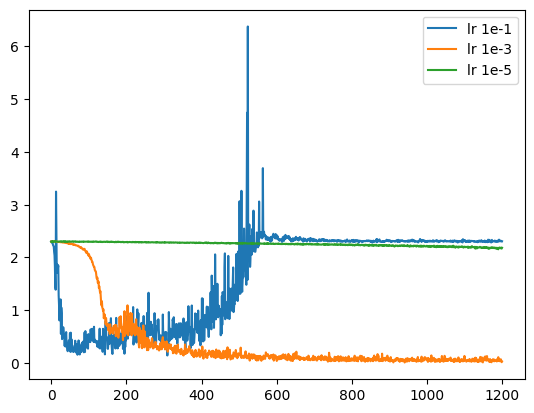

In [19]:
# --------------- YOUR CODE HERE ---------------

loss_graphs = []
for learning_rate in [1e-1, 1e-3, 1e-5]:
    net = Net(drop=False).to(device)
    loss, acc = train(MNIST_train, net, net.parameters(), 'SGD', learning_rate=learning_rate, epochs=4)
    print('Learning rate:{}'.format(learning_rate))
    print('Accuracy:{}'.format(test(MNIST_test, net)))
    loss_graphs.append(loss)

## plot three loss curves on same plot
ax=range(len(loss_graphs[0]))
plt.plot(ax, loss_graphs[0], ax, loss_graphs[1], ax, loss_graphs[2])
plt.legend(['lr 1e-1', 'lr 1e-3', 'lr 1e-5'])
plt.show()

  0%|          | 0/4 [00:00<?, ?it/s]100%|██████████| 4/4 [02:40<00:00, 40.06s/it]


Learning rate:0.1
Accuracy:0.0982


100%|██████████| 4/4 [02:41<00:00, 40.49s/it]


Learning rate:0.001
Accuracy:0.9836


100%|██████████| 4/4 [02:41<00:00, 40.31s/it]


Learning rate:1e-05
Accuracy:0.4717


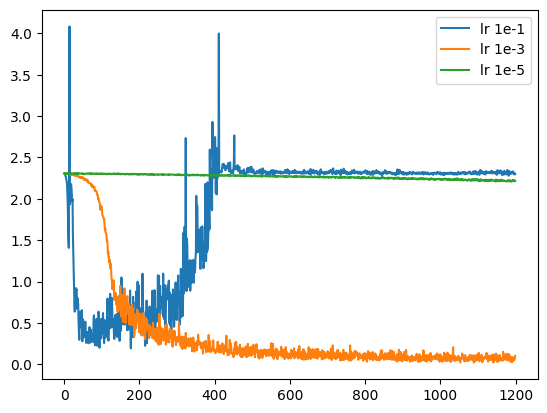

In [20]:
# --------------- YOUR CODE HERE ---------------
loss_graphs = []
for learning_rate in [1e-1, 1e-3, 1e-5]:
    net = Net(drop=True).to(device)
    loss, acc = train(MNIST_train, net, net.parameters(), 'SGD', learning_rate=learning_rate, epochs=4)
    print('Learning rate:{}'.format(learning_rate))
    print('Accuracy:{}'.format(test(MNIST_test, net)))
    loss_graphs.append(loss)

## plot three loss curves on same plot
ax=range(len(loss_graphs[0]))
plt.plot(ax, loss_graphs[0], ax, loss_graphs[1], ax, loss_graphs[2])
plt.legend(['lr 1e-1', 'lr 1e-3', 'lr 1e-5'])
plt.show()

# 3. Transfer learning [15 Points]

You will now visualize the effects of transfer learning by performing experiments using the SVHN dataset (http://ufldl.stanford.edu/housenumbers/) . Note that this is just to understand how transfer learning works, in practice it is generally used with very large datasets and complex networks.

In [4]:
!mkdir SVHN
%cd SVHN
!wget -nc http://ufldl.stanford.edu/housenumbers/train_32x32.mat
%cd ..

# Convert .mat files to np arrays
import scipy.io as sio
import numpy as np

def load_data(path):
    data = sio.loadmat(path)
    return np.array(data['X']), np.array(data['y'])

data, labels = load_data('SVHN/train_32x32.mat')

data = data.transpose((3, 2, 0, 1))
labels  = labels.reshape(-1)

 **[ 2 points ] Plot 3 random images corresponding to each label from the training data**


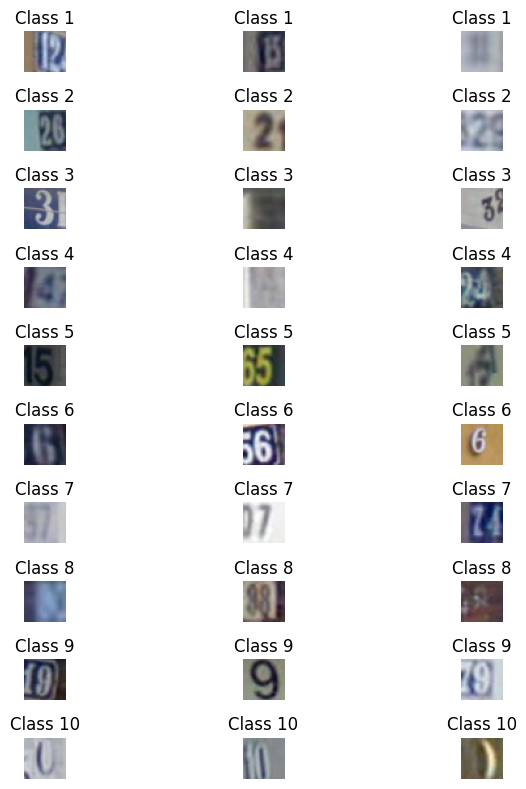

In [8]:
import random
import matplotlib.pyplot as plt
# --------------- YOUR CODE HERE ---------------
## Plot 3 random images from all classes in the SVHN dataset, so a total of 30 images for all the classes

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 10

for i in range(10):
    class_indices = np.where(labels == i+1)[0]
    random_indices = random.sample(list(class_indices), 3)
    
    for j, idx in enumerate(random_indices):
        image = data[idx]
        ax = figure.add_subplot(rows, cols, i * cols + j + 1)
        ax.axis("off")
        ax.imshow(image.transpose(1, 2, 0))
        ax.set_title(f"Class {i+1}")
        
plt.tight_layout()
plt.show()


We will split the dataset into two parts, one with labels 0-4 and other with labels 5-9, we have provided this code for you. This should print the sizes of data and labels in each split.

In [9]:
# Split the data and labels into two sets corresponding to labels 0-4 and 5-9.
data1 = np.zeros((0, 3, 32, 32))
labels1 = []
data2 = np.zeros((0, 3, 32, 32))
labels2 = []

## SVHN has labels in the range 1-10 and not 0-9. 
# Split data and labels for labels 0 to 4
for i in range(5):
    x = data[labels == i+1][:5000]
    data1 = np.vstack((data1, x))
    labels1 += [i] * len(x)

# Split data and labels for labels 5 to 9
for i in range(5, 10):
    x = data[labels == i+1][:5000]
    data2 = np.vstack((data2, x))
    labels2 += [i] * len(x)

## Neural networks always accept labels in the range 0 to n-1.
## change data from cardinal to ordinal.
labels1 = np.array(labels1)
labels2 = np.array(labels2) - 5

data1.shape, data2.shape, labels1.shape, labels2.shape

## should print ((25000, 3, 32, 32), (24607, 3, 32, 32), (25000,), (24607,))

((25000, 3, 32, 32), (24607, 3, 32, 32), (25000,), (24607,))

**[ 3 points ] Create a simple convolutional network to classify the training data. The network structure should be as follows:**

1. Layer 1 - Convolutional layer with kernel size 4, Stride 2, Output channels 5, Relu activation
2. Layer 2 - Convolutional layer with kernel size 4, Stride 1, Output channels 10, Relu avtication
3. Layer 3 - Convolutional layer with kernel size 4, Stride 1, Output channels 20, Relu activation
4. Layer 4 - Convolutional layer with kernel size 4, Stride 1, Output channels 40, Relu activation
5. Layer 5 - Fully connected layer with 5 outputs

In [12]:
class Net(nn.Module):
    def __init__(self, n_labels=5):
        super().__init__()
        # --------------- YOUR CODE HERE ---------------

        self.layer1 = nn.Conv2d(3, 5, 4, stride=2)
        self.layer2 = nn.Conv2d(5, 10, 4, stride=1) 
        self.layer3 = nn.Conv2d(10, 20, 4, stride=1)
        self.layer4 = nn.Conv2d(20, 40, 4, stride=1)
        self.fc = nn.Linear(40*6*6, n_labels)

        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        # --------------- YOUR CODE HERE ---------------
        x = self.layer1(x)
        x = self.relu(x)

        x = self.layer2(x)
        x = self.relu(x)

        x = self.layer3(x)
        x = self.relu(x)

        x = self.layer4(x)
        x = self.relu(x)

        x = x.view(-1, 40*6*6)
        x = self.fc(x)

        return x

net = Net()
print(net)

Net(
  (layer1): Conv2d(3, 5, kernel_size=(4, 4), stride=(2, 2))
  (layer2): Conv2d(5, 10, kernel_size=(4, 4), stride=(1, 1))
  (layer3): Conv2d(10, 20, kernel_size=(4, 4), stride=(1, 1))
  (layer4): Conv2d(20, 40, kernel_size=(4, 4), stride=(1, 1))
  (fc): Linear(in_features=1440, out_features=5, bias=True)
  (relu): ReLU(inplace=True)
)


**[ 5 points ] Complete the train function below and follow the instructions**

* Initialize the network, train the complete network (net.parameters) on data1 (The first 5 classes)
* Plot the loss and accuracy graphs over training on the same plot
* Print the final training accuracy as well**

Set the learning rate, number of iterations and batch size such that the loss is gradually and smoothly decreasing and converging. The accuracy at the end of training must be around or greater than 55 %.

In [19]:
# to_train can be net.paramaters OR net.fc.parameters OR net.conv1.parameters so that only certain parts of the net are trained
def train(tdata,tlabel,net,to_train):
    criterion = nn.CrossEntropyLoss()
    losslist = []
    acclist = [] # Hint: use argmax to find the index with the largest value

    # YOU MAY NEED TO CHANGE THESE PARAMETERS TO IMPROVE ACCURACY
    epochs=15
    batch=256
    learning_rate=1e-3
    optimizer = optim.SGD(to_train,lr=learning_rate)
    optimizer.zero_grad()

    for k in tqdm(range(epochs)):
        ## Shuffle the data
        indices = np.arange(len(tdata))
        np.random.shuffle(indices)
        tdata = tdata[indices]
        tlabel = tlabel[indices]

        for l in range(int(len(tdata)/batch)):

            inputs = torch.FloatTensor(tdata[l*batch:(l+1)*batch]).to(device)
            targets = torch.LongTensor(tlabel[l*batch:(l+1)*batch]).to(device)
            # --------------- YOUR CODE HERE ---------------

            pred = net(inputs)
            loss = criterion(pred, targets)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            losslist.append(loss.item())
            acclist.append((pred.argmax(1) == targets).type(torch.float).mean().item())

    return losslist,acclist

100%|██████████| 15/15 [01:44<00:00,  6.99s/it]


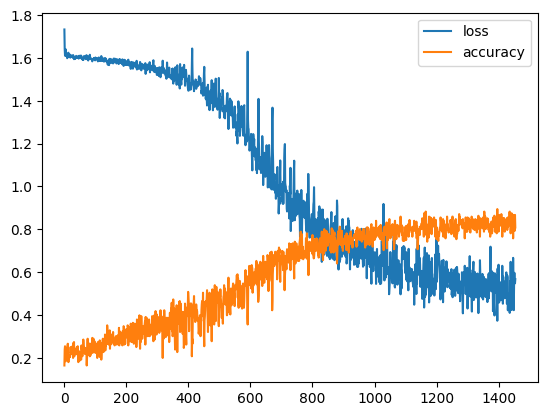

Accuracy:0.80859375


In [20]:
# --------------- YOUR CODE HERE ---------------
net = Net()
loss1, acc1 = train(data1, labels1, net, net.parameters())
ax=range(len(loss1))
plt.plot(ax, loss1, ax, acc1)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(acc1[-1]))

**[ 2 points ] Without reinitializing the network, train only the fully connected layer (net.fc.parameters) now on data2 (The next 5 classes)**

Do not change any hyper parameters such as learning rate or batch size. Plot the loss and accuracy and print the final values like before.

100%|██████████| 15/15 [01:43<00:00,  6.90s/it]


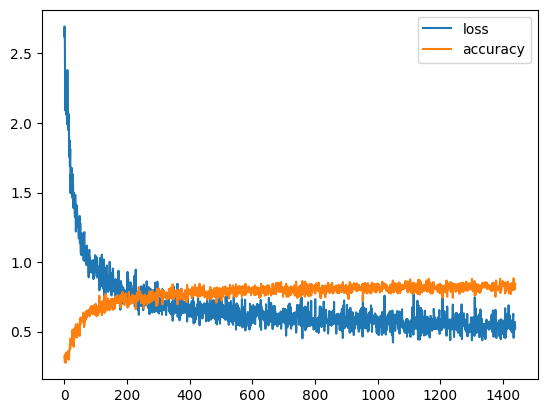

Accuracy:0.84375


In [21]:
# --------------- YOUR CODE HERE ---------------
loss2, acc2 = train(data2, labels2, net, net.fc.parameters())
ax=range(len(loss2))
plt.plot(ax, loss2, ax, acc2)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(acc2[-1]))

**[ 3 points ] Now repeat the process in the opposite order**

* Initialize the net again, train the whole network on data2, generate the same plots as before
* Then without reinitializing the net, train only the fully connected layer on data1 and generate the plots

Do not change any hyperparameters.

100%|██████████| 15/15 [01:47<00:00,  7.14s/it]


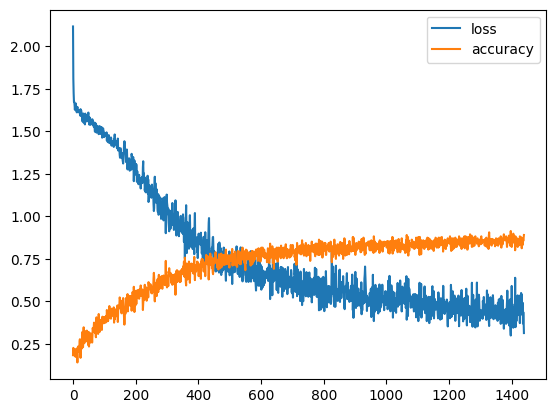

Accuracy:0.890625


In [22]:
# --------------- YOUR CODE HERE ---------------
net_2 = Net()
loss3, acc3 = train(data2, labels2, net_2, net_2.parameters())
ax=range(len(loss3))
plt.plot(ax, loss3, ax, acc3)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(acc3[-1]))

100%|██████████| 15/15 [01:49<00:00,  7.33s/it]


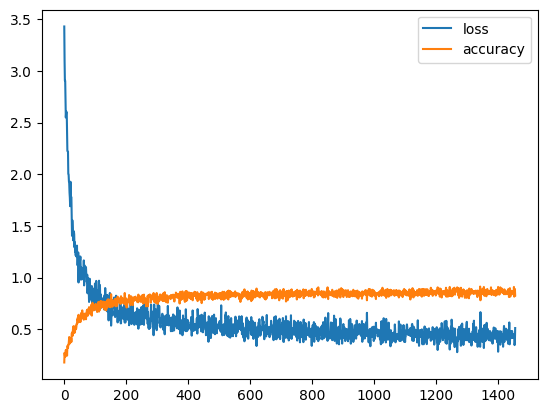

Accuracy:0.828125


In [23]:
# --------------- YOUR CODE HERE ---------------
loss4, acc4 = train(data1, labels1, net_2, net_2.fc.parameters())
ax=range(len(loss4))
plt.plot(ax, loss4, ax, acc4)
plt.legend(['loss', 'accuracy'])
plt.show()
print('Accuracy:{}'.format(acc4[-1]))

**[ 5 points ]**

* Plot the accuracy vs iterations for the classifers trained to classify data1, via normal learning as well as transfer learning, on the same plot
* Plot another graph for the classifiers trained to classify data2

Explain the results obtained, based on the training regimen. Comment on why transfer learning worked/didn't work.

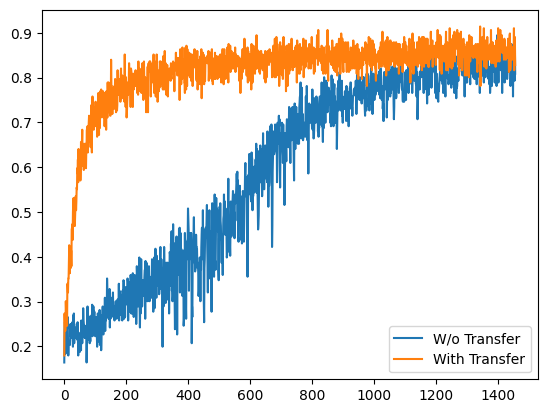

W/o Transfer: 0.80859375 With Transfer: 0.828125


In [29]:
ax = range(len(loss1))
plt.plot(ax, acc1, ax, acc4)
plt.legend(['W/o Transfer', 'With Transfer'])
plt.show()

print("W/o Transfer:", acc1[-1], "With Transfer:", acc4[-1])

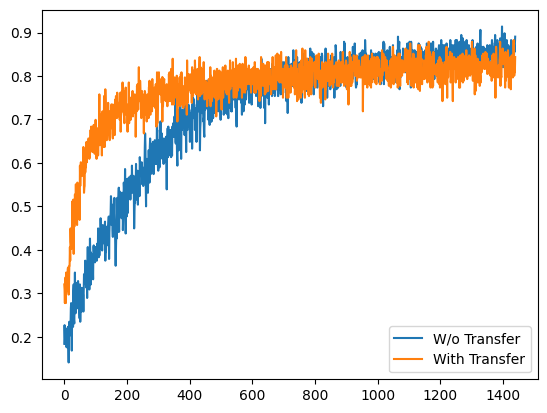

W/o Transfer: 0.890625 With Transfer: 0.84375


In [28]:
ax = range(len(loss2))
plt.plot(ax, acc3, ax, acc2)
plt.legend(['W/o Transfer', 'With Transfer'])
plt.show()

print("W/o Transfer:", acc3[-1], "With Transfer:", acc2[-1])

#### Inference: We can see that transfer learning worked on data 1 but did not quite work on data 2.

**Optional**: Create a network with more layers, pooling layers, and more filters and try to increase accuracy as much as possible. Play around with the hyperparameters to understand how they affect the training process. No need to turn in anything for this.